# Environment Setup

Mount google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd  /content/drive/MyDrive/'ML Project'/refactoring/

/content/drive/MyDrive/ML Project/refactoring


Import dependences.

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from utils import load_images, get_merged_animal_names, get_merged_animal_labels, plot_history, construct_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
folder_path = "/content/drive/My Drive/ML Project/refactoring"

# Data Preparation

The following code loads images from directory, resizes and saves into .npy files with corresponding labels.

As we already have saved .npy files, skip it.

In [ ]:
# load_images(folder_path=folder_path, img_shape=(224, 224))

Load saved images and labels.

In [ ]:
images = np.load(os.path.join(folder_path, "data/images_224.npy"))
labels = np.load(os.path.join(folder_path, "data/labels.npy")).astype(np.int8)

print(f"Number of Images: {images.shape[0]}, Image Size: {images.shape[1:3]}, Number of Channels: {images.shape[3]}")
print(f"Number of Unique labels: {len(np.unique(labels))}")

Number of Images: 5400, Image Size: (224, 224), Number of Channels: 3
Number of Unique labels: 90


Get new merged animal names and labels.

In [ ]:
merged_animal_names = get_merged_animal_names()
merged_labels = get_merged_animal_labels(labels)

print(f"Number of Unique labels: {len(np.unique(merged_labels))}")

Number of Unique labels: 68


Define ImageDataGenerator for Data Augmentation, which uses horizontal flip and rotation of degree 10.

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True
)

# Custom CNN Architecture

### Data Preparation

Rescale image values from [0, 255] to [0, 1] for efficient training process.

In [ ]:
images_scaled = (images / 255)
images_scaled = images_scaled.astype(np.float16)

Split into training and test datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_scaled, merged_labels, test_size=0.1, random_state=1)

### Model

Define custom CNN architecture.

In [ ]:
model = tf.keras.Sequential([
    layers.Input((224, 224, 3)),

    layers.Conv2D(8, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),

    layers.Dropout(0.5),

    layers.Flatten(),

    layers.Dense(512, activation="relu", kernel_regularizer="l2"),
    layers.Dropout(0.4),

    layers.Dense(68, activation="softmax")
])

Compile using Sparse Categorical CrossEntropy loss, Adam optimizer and Accuracy metrics.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### Training

As we already have saved model, skip the training and saving process.

In [ ]:
# history = model.fit(datagen.flow(x=X_train, y=y_train, batch_size=32), epochs=2, validation_data=(X_test, y_test))

In [ ]:
# model.save(os.path.join(folder_path, "/models/model.keras"))

Load pretrained weights to skip training process.

In [ ]:
model = load_model(os.path.join(folder_path, 'models/model.keras'))

### Results

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


Results on the validation set.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-score (macro): {f1:.3f}")

Accuracy: 0.433
Precision (macro): 0.488
Recall (macro): 0.417
F1-score (macro): 0.419


Training and Validation Loss during training process.

In [ ]:
# plot_history(history)

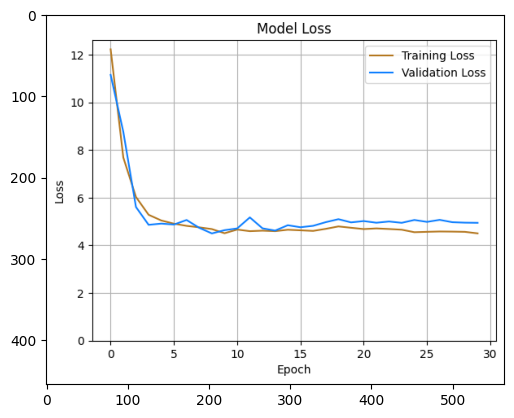

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/model_loss.png")))

Training and Validation Accuracy during training process.

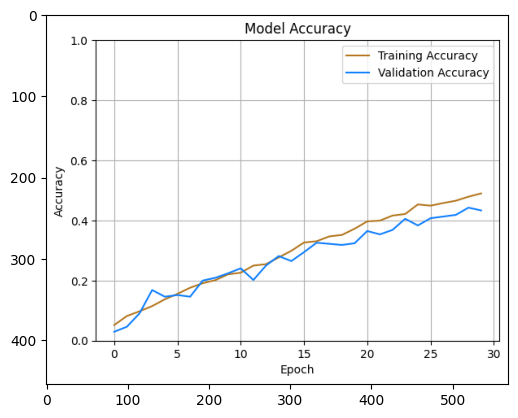

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/model_accuracy.png")))

Confussion Matrix.

In [ ]:
construct_confusion_matrix(merged_animal_names, y_test, y_pred)

True: Bear/Boar       Predicted: Elephant/Rhino  Confused 4 times
True: hippopotamus    Predicted: Elephant/Rhino  Confused 3 times
True: Elephant/Rhino  Predicted: Bison/Ox/Cow    Confused 3 times
True: goldfish        Predicted: parrot          Confused 3 times
True: Bison/Ox/Cow    Predicted: Horse/Donkey    Confused 3 times
True: Raccoon/Possum  Predicted: squirrel        Confused 2 times
True: goat            Predicted: sheep           Confused 2 times
True: hare            Predicted: Deer/Antelope   Confused 2 times
True: Dolphin/Whale   Predicted: turtle          Confused 2 times
True: Butterfly/Moth  Predicted: turtle          Confused 2 times


In [ ]:
del images_scaled, X_train, X_test

# Transfer Learning

Because of small dataset size, we will now use pretrained models for feature extraction.

## MobileNetV2

### Data Preparation for MobileNetV2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

Process the input data to match pretrained range of values.

Split into training and test datasets.

In [ ]:
mn_v2_images = mobilenet_v2_preprocess_input(images)
X_train, X_test, y_train, y_test = train_test_split(mn_v2_images, merged_labels, test_size=0.1, random_state=1)

### Model

Use MobileNetV2 as a base model for feature extraction, make its weights non-trainable and define custom final layers.

In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    layers.Input((224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(68, activation='softmax')
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Compile using Sparse Categorical CrossEntropy loss, Adam optimizer and Accuracy metrics.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### Training

As we already have saved model, skip the training and saving process.

In [ ]:
# history = model.fit(datagen.flow(x=X_train, y=y_train, batch_size=32), epochs=5, validation_data=(X_test, y_test))

In [ ]:
# model.save("models/base_model_mobile_net_v2.keras")

Load pretrained weights to skip training process.

In [ ]:
model = load_model(os.path.join(folder_path, "models/base_model_mobilenet.keras"))

### Results

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step


Results on the validation set.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-score (macro): {f1:.3f}")

Accuracy: 0.893
Precision (macro): 0.913
Recall (macro): 0.879
F1-score (macro): 0.885


Training and Validation Loss during training process.

In [ ]:
# plot_history(history)

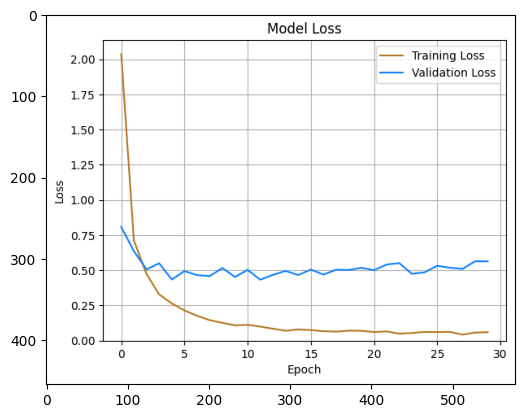

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/mobilenet_v2_loss.png")))

Training and Validation Accuracy during training process.

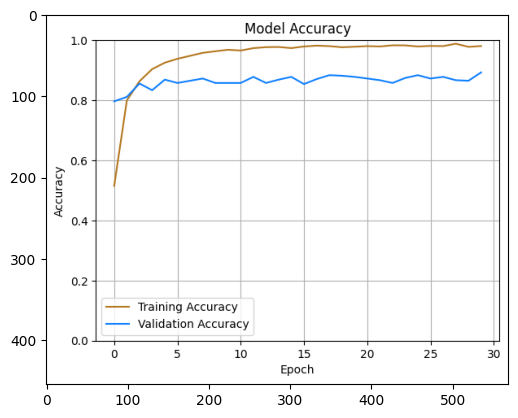

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/mobilenet_v2_accuracy.png")))

Confussion Matrix.

In [ ]:
construct_confusion_matrix(merged_animal_names, y_test, y_pred)

True: okapi           Predicted: Horse/Donkey    Confused 2 times
True: goat            Predicted: Horse/Donkey    Confused 2 times
True: caterpillar     Predicted: Butterfly/Moth  Confused 2 times
True: Beetle/Ladybug  Predicted: cockroach       Confused 2 times
True: Octopus/Squid   Predicted: Rodents         Confused 1 times
True: Butterfly/Moth  Predicted: lizard          Confused 1 times
True: Butterfly/Moth  Predicted: bat             Confused 1 times
True: tiger           Predicted: bat             Confused 1 times
True: grasshopper     Predicted: jellyfish       Confused 1 times
True: lizard          Predicted: caterpillar     Confused 1 times


In [ ]:
del mn_v2_images, X_train, X_test

## ResNet50

### Data Preparation for ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50

Process the input data to match pretrained range of values.

Split into training and test datasets.

In [ ]:
resnet_50_images = resnet50_preprocess_input(images)

X_train, X_test, y_train, y_test = train_test_split(resnet_50_images, merged_labels, test_size=0.1, random_state=1)

### Model

Use ResNet50 as a base model for feature extraction, make its weights non-trainable and define custom final layers.

In [ ]:
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(68, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Compile using Sparse Categorical CrossEntropy loss, Adam optimizer and Accuracy metrics.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### Training

As we already have saved model, skip the training and saving process.

In [ ]:
# history = model.fit(datagen.flow(x=X_train, y=y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test), verbose=2)

In [ ]:
# model.save("./models/base_model_resnet50.keras")

Load pretrained weights to skip training process.

In [ ]:
model = load_model(os.path.join(folder_path, 'models/base_model_resnet50.keras'))

### Results

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step


Results on the validation set.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-score (macro): {f1:.3f}")

Accuracy: 0.878
Precision (macro): 0.899
Recall (macro): 0.873
F1-score (macro): 0.873


Training and Validation Loss during training process.

In [ ]:
# plot_history(history)

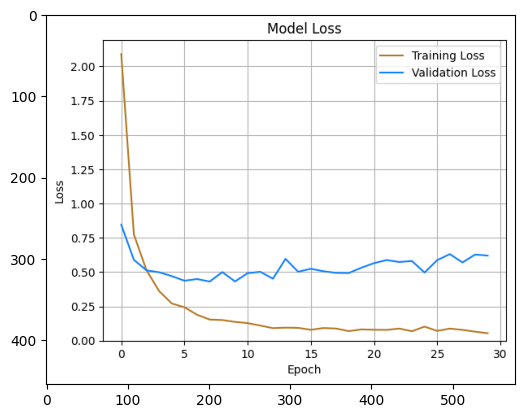

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/resnet50_loss.png")))

Training and Validation Accuracy during training process.

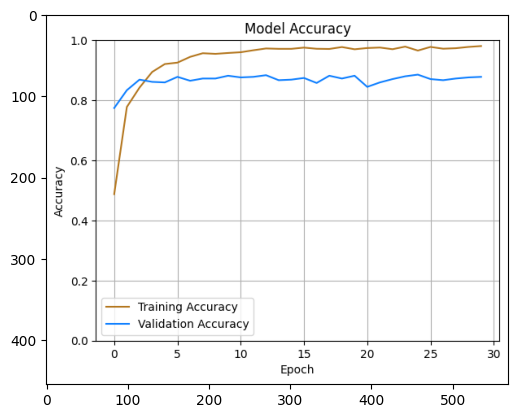

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/resnet50_accuracy.png")))

Confussion Matrix.

In [ ]:
construct_confusion_matrix(merged_animal_names, y_test, y_pred)

True: Rodents         Predicted: Raccoon/Possum  Confused 3 times
True: wombat          Predicted: Rodents         Confused 2 times
True: caterpillar     Predicted: lizard          Confused 2 times
True: shark           Predicted: Dolphin/Whale   Confused 2 times
True: tiger           Predicted: lizard          Confused 1 times
True: hippopotamus    Predicted: Elephant/Rhino  Confused 1 times
True: owl             Predicted: leopard         Confused 1 times
True: Fly/Mosquito    Predicted: cockroach       Confused 1 times
True: kangaroo        Predicted: Bison/Ox/Cow    Confused 1 times
True: lizard          Predicted: owl             Confused 1 times


In [ ]:
del resnet_50_images, X_train, X_test

## EfficientNetB0

### Data Preparation for EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

Process the input data to match pretrained range of values.

Split into training and test datasets.

In [ ]:
efficientnet_images = efficientnet_preprocess_input(images)

X_train, X_test, y_train, y_test = train_test_split(efficientnet_images, merged_labels, test_size=0.1, random_state=1)

### Model

Use EfficientNetB0 as a base model for feature extraction, make its weights non-trainable and define custom final layers.

In [ ]:
base_model =  EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    layers.Input((224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(68, activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Compile using Sparse Categorical CrossEntropy loss, Adam optimizer and Accuracy metrics.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### Training

As we already have saved model, skip the training and saving process.

In [ ]:
# history = model.fit(datagen.flow(x=X_train, y=y_train, batch_size=32), epochs=2, validation_data=(X_test, y_test), verbose=2)

In [ ]:
# model.save(os.path.join(folder_path, "models/base_model_EfficientNet_b0.keras"))

Load pretrained weights to skip training process.

In [ ]:
model = load_model(os.path.join(folder_path, 'models/base_model_efficientnet.keras'))

### Results

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step


Results on the validation set.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-score (macro): {f1:.3f}")

Accuracy: 0.924
Precision (macro): 0.928
Recall (macro): 0.917
F1-score (macro): 0.917


Training and Validation Loss during training process.

In [ ]:
# plot_history(history)

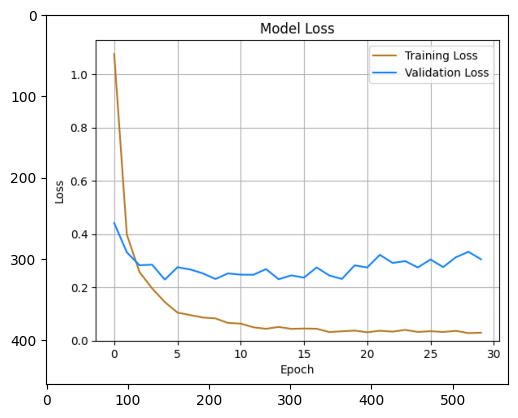

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/efficientnet_b0_loss.png")))

Training and Validation Accuracy during training process.

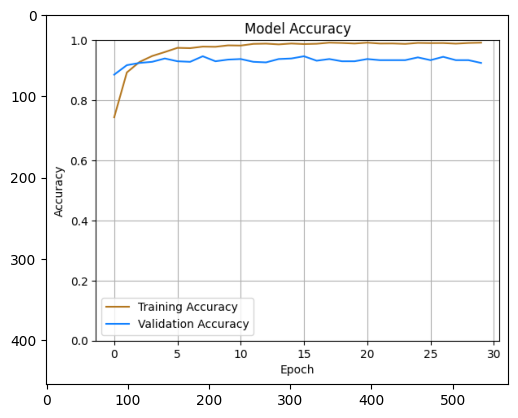

In [ ]:
plt.imshow(cv2.imread(os.path.join(folder_path, "plots/efficientnet_b0_accuracy.png")))

Confussion Matrix.

In [ ]:
construct_confusion_matrix(merged_animal_names, y_test, y_pred)

True: turtle          Predicted: Dolphin/Whale   Confused 2 times
True: dog             Predicted: wolf            Confused 1 times
True: parrot          Predicted: pig             Confused 1 times
True: hare            Predicted: cat             Confused 1 times
True: panda           Predicted: Raccoon/Possum  Confused 1 times
True: Beetle/Ladybug  Predicted: cockroach       Confused 1 times
True: owl             Predicted: sheep           Confused 1 times
True: grasshopper     Predicted: Crustaceans     Confused 1 times
True: caterpillar     Predicted: Butterfly/Moth  Confused 1 times
True: turkey          Predicted: dog             Confused 1 times


In [ ]:
del efficientnet_images, X_train, X_test